In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

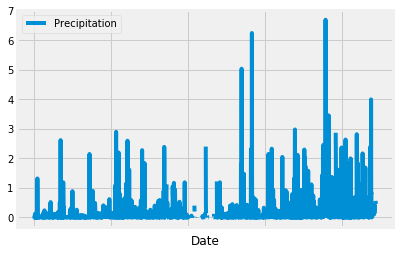

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

#get earliest and latest dates, calculate date 1 year ago from the last data point in the database
#date range is 01/01/2010 - 8/23/2017 
# earliest_date = session.query(Measurement.date).order_by(Measurement.date).first()
# latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = session.query(func.max(Measurement.date)).all()
latest_date_format = dt.datetime.strptime(latest_date[0][0], "%Y-%m-%d")
start_date = latest_date_format - dt.timedelta(days=365)

#query to retrieve precipitation amount in past 12 months
precip_info = session.query (Measurement.station, Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= start_date).all()

#pandas dataframe and sort by date, set index to date column, sort df by date
precip_df = pd.DataFrame(precip_info, columns=["Station", "Date", "Precipitation"])
precip_df.set_index("Date", inplace=True)
precip_df.sort_values("Date", ascending=True)

#plot with pandas
precip_plot = precip_df.plot()
precip_plot

![precipitation](Images/precipitation.png)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [12]:
#Design a query to calculate the total number of stations.
stations_amount = session.query(Measurement.station).distinct().count()
stations_amount

9

In [13]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    filter(Measurement.station.isnot(None)).order_by(func.count(Measurement.station).desc()).\
    group_by(Measurement.station)

for x in active_stations:
    print(x)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
#highest temperature recorded, and average temperature most active station?

temp_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == "USC00519281")

for x in temp_station:
    print(x)

(54.0, 85.0, 71.66378066378067)


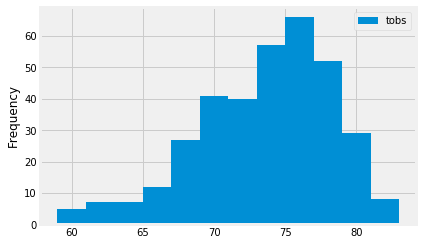

In [15]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp12 = session.query(Measurement.station, func.count(Measurement.tobs)).filter(Measurement.tobs.isnot(None)).\
    order_by(func.count(Measurement.tobs).desc()).group_by(Measurement.station)
station12 = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date > start_date).\
    filter(Measurement.station == "USC00519281").all()
hitemp_df = pd.DataFrame(station12, columns=["Date", "tobs"])
hitemp_df.iloc[::-1].plot.hist(bins=12)

![precipitation](Images/station-histogram.png)

FLASK SECTION

In [16]:
#import dependecies
from flask import Flask, jsonify

In [17]:
#create app
app = Flask(__name__)

In [18]:
#create routes
#route 1 - Home page
@app.route("/")
def home():
    "Available API routes"
    return(
        f"/api/v1.0/precipitation <br/>"
        f"/api/v1.0/stations <br/>"
        f"/api/v1.0/tobs <br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [19]:
#route 2 - precipication
@app.route("/api/v1.0/precipitation")
def precipitation():
    precip_dict = []
    for station, date, prcp in precip_info:
        prcp = {}
        prcp["Date"] = date
        prcp["Precipitaiton"] = prcp
        precip_dict.append(prcp)
    return jsonify(precip_dict)

In [20]:
#route 3 - stations
@app.route("/api/v1.0/stations")
def station():
    station_dict = []
    for station in active_stations:
        station2 = {}
        station2["Station"] = station
        station_dict.append(station2)
    return jsonify(station_dict)

In [21]:
#route 4 - tobs
@app.route("/api/v1.0/tobs")
def tobs():
    tobs_dict = []
    for date, tob in active_stations:
        tobdict = {}
        tobdict["Date"] = date
        tobdict["Tobs"] = tobs
        tobs_dict.append(tobdict)
    return jsonify(tobs_dict)